In [7]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, vgg16, efficientnet_b0
from torchvision.models import ResNet50_Weights, VGG16_Weights, EfficientNet_B0_Weights
from scipy.spatial.distance import cosine
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
%matplotlib inline



In [8]:
# Function to display an image
def show_image(image_path, title="Image"):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct display
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to display grayscale images
def show_grayscale_image(image, title="Grayscale Image"):
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Function to display SIFT matches
def show_sift_matches(image1_path, image2_path, kp1, kp2, matches):
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    match_img = cv2.drawMatches(
        img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(match_img)
    plt.title("SIFT Matches")
    plt.axis("off")
    plt.show()


In [17]:
# Compute SSIM
def compute_ssim(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize to ensure consistent dimensions
    img1 = cv2.resize(img1, (256, 256))
    img2 = cv2.resize(img2, (256, 256))
    
    show_grayscale_image(img1, title="Grayscale Image 1 for SSIM")
    show_grayscale_image(img2, title="Grayscale Image 2 for SSIM")
    
    similarity, _ = ssim(img1, img2, full=True)
    return similarity

# Compute SIFT Matches
def sift_similarity(image1_path, image2_path):
    sift = cv2.SIFT_create()
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    
    if des1 is None or des2 is None:
        return 0, 0, 0, [], [], []
    
    # Match descriptors using FLANN
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    return len(good_matches), len(kp1), len(kp2), kp1, kp2, good_matches

# Extract features using deep learning models
def extract_features_dl(image_path, model, transform):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = transform(img).unsqueeze(0)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()

def compute_cosine_similarity(features1, features2):
    return 1 - cosine(features1, features2)


In [18]:
# Load pretrained models
def load_models():
    models = {
        "ResNet50": resnet50(weights=ResNet50_Weights.DEFAULT),
        "VGG16": vgg16(weights=VGG16_Weights.DEFAULT),
        "EfficientNet_B0": efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT),
    }
    return models

models = load_models()


In [19]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


ResNet50 Cosine Similarity: 0.6695
VGG16 Cosine Similarity: 0.7140
EfficientNet_B0 Cosine Similarity: 0.5984


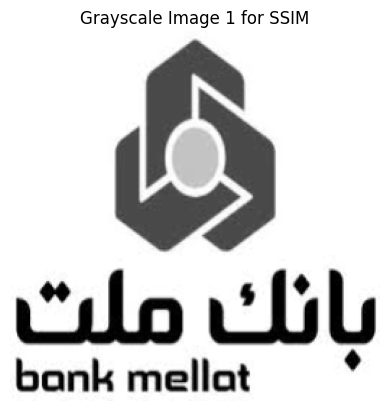

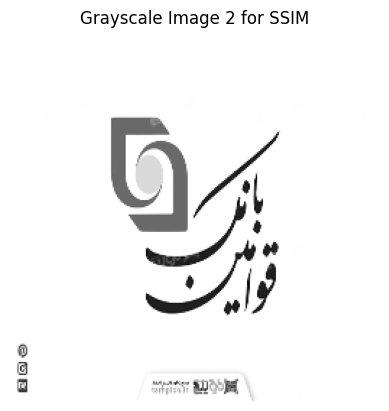

SSIM Score: 0.5609


In [25]:
# Replace with your image paths
# img1_path = "path_to_first_image.jpg"
# img2_path = "path_to_second_image.jpg"
img1= 'bankmellat_pic3.jpeg'
img2 = 'bankghavamin_pic7.jpg'
  
img1_path = f"/home/mahdi/Phishing_Project/images/{img1}"
img2_path = f"/home/mahdi/Phishing_Project/images/{img2}"
# Deep Learning Comparisons
for name, model in models.items():
    model.fc = torch.nn.Identity()  # Remove classification layer for ResNet
    model.eval()
    similarity = compute_cosine_similarity(
        extract_features_dl(img1_path, model, transform),
        extract_features_dl(img2_path, model, transform)
    )
    print(f"{name} Cosine Similarity: {similarity:.4f}")

# SSIM
ssim_score = compute_ssim(img1_path, img2_path)
print(f"SSIM Score: {ssim_score:.4f}")

# SIFT
# good_matches, kp1, kp2 = sift_similarity(img1_path, img2_path)
# print(f"Number of good matches: {good_matches}")
# print(f"Keypoints in Image 1: {kp1}, Image 2: {kp2}")
# print(f"SIFT Match Ratio: {good_matches / min(kp1, kp2):.4f}")


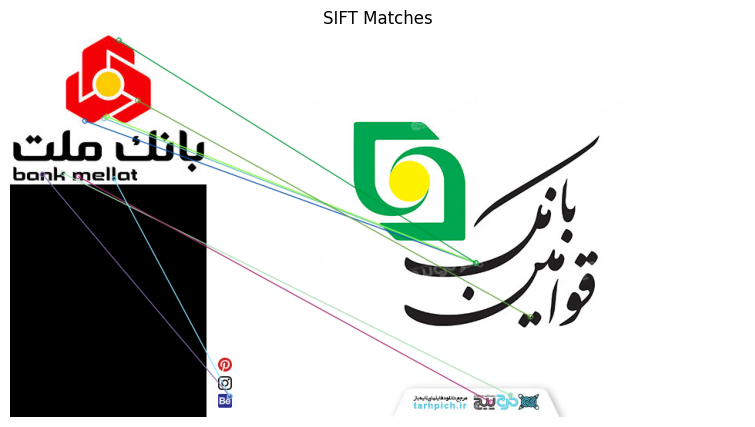

In [21]:
good_matches, kp1, kp2, keypoints1, keypoints2, matches = sift_similarity(img1_path, img2_path)
show_sift_matches(img1_path, img2_path, keypoints1, keypoints2, matches)

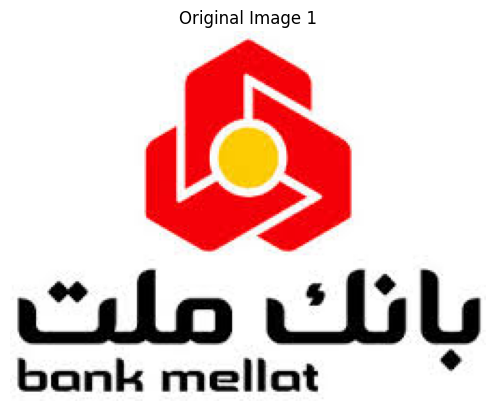

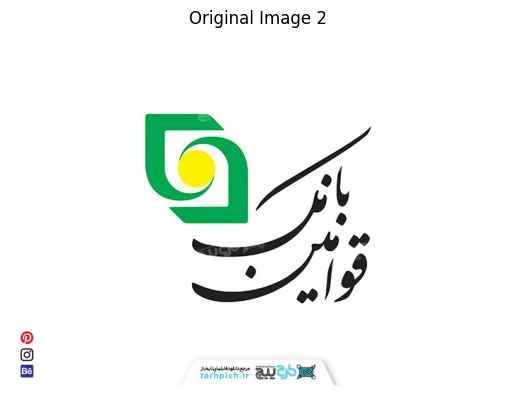

In [22]:
show_image(img1_path, title="Original Image 1")
show_image(img2_path, title="Original Image 2")


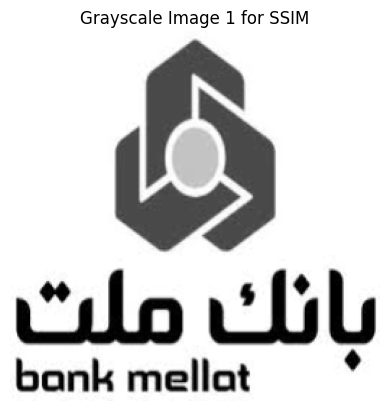

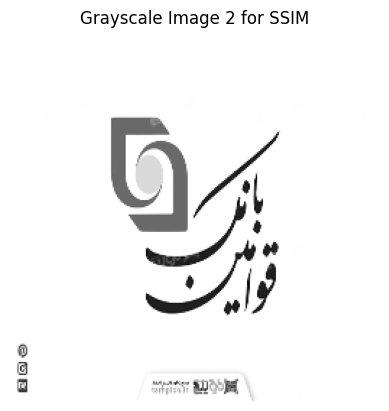

SSIM Score: 0.5609


In [23]:
ssim_score = compute_ssim(img1_path, img2_path)
print(f"SSIM Score: {ssim_score:.4f}")


Number of good matches: 9
Keypoints in Image 1: 228, Image 2: 221
SIFT Match Ratio: 0.0407


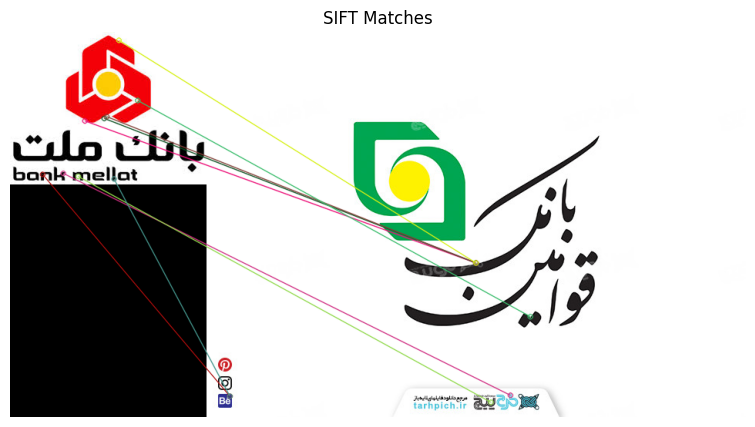

In [24]:
good_matches, kp1, kp2, keypoints1, keypoints2, matches = sift_similarity(img1_path, img2_path)
print(f"Number of good matches: {good_matches}")
print(f"Keypoints in Image 1: {kp1}, Image 2: {kp2}")
print(f"SIFT Match Ratio: {good_matches / min(kp1, kp2):.4f}")
show_sift_matches(img1_path, img2_path, keypoints1, keypoints2, matches)
